In [ ]:
# Import all required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import VGG16
import pickle
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)All

All libraries imported successfully!
TensorFlow version: 2.20.0
Keras version: 3.12.0


In [33]:
# Download the data and Unzip in the allocated google cloud-server. If already down, turn downloadData=False
downloadData = True
if downloadData == True:
  indrive = False
  if indrive == True:
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip -P "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
    !unzip "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images.zip" -d "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/"
    !ls "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
  else: #incloud google server
    !rm -rf cell_images.*
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
    !unzip cell_images.zip >/dev/null 2>&1
    !ls

--2025-11-26 00:24:04--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 2600:9000:2054:400:3:cecb:bc80:93a1, 2600:9000:2054:aa00:3:cecb:bc80:93a1, 2600:9000:2054:a800:3:cecb:bc80:93a1, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|2600:9000:2054:400:3:cecb:bc80:93a1|:443... 2600:9000:2054:400:3:cecb:bc80:93a1, 2600:9000:2054:aa00:3:cecb:bc80:93a1, 2600:9000:2054:a800:3:cecb:bc80:93a1, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|2600:9000:2054:400:3:cecb:bc80:93a1|:443... connected.
connected.
HTTP request sent, awaiting response... HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip       0%[                    ]       0  --.-KB/s               200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M  5.

In [34]:
# Explore the dataset structure /home/belysetag/malaria-diagnosis-ml-pipeline/data
data = '/home/belysetag/malaria-diagnosis-ml-pipeline/data'
print(f"Data directory contents: {os.listdir(data)}")
test= os.path.join(data, 'test')
train = os.path.join(data, 'train')
print(f"Train directory contents: {os.listdir(train)}")
print(f"Test directory contents: {os.listdir(test)}")

# Count images in each class 
Parasitized = len(os.listdir(os.path.join(train, 'Parasitized')))
Uninfected = len(os.listdir(os.path.join(train, 'Uninfected')))


# Calculate class distribution
total_images = Parasitized + Uninfected
parasitized_ratio = Parasitized / total_images
uninfected_ratio = Uninfected / total_images

print(f"Parasitized images: {Parasitized} ({parasitized_ratio:.2%})")
print(f"Uninfected images: {Uninfected} ({uninfected_ratio:.2%})")

# Count images in test and train for both classes
train_parasitized = len(os.listdir(os.path.join(train, 'Parasitized')))
train_uninfected = len(os.listdir(os.path.join(train, 'Uninfected')))
test_parasitized = len(os.listdir(os.path.join(test, 'Parasitized')))
test_uninfected = len(os.listdir(os.path.join(test, 'Uninfected')))
print(f"Training set - Parasitized: {train_parasitized}, Uninfected: {train_uninfected}")
print(f"Test set - Parasitized: {test_parasitized}, Uninfected: {test_uninfected}")
print(f"Total training images: {train_parasitized + train_uninfected}")
print(f"Total test images: {test_parasitized + test_uninfected}")


Data directory contents: ['test', 'train']
Train directory contents: ['Parasitized', 'Uninfected']
Test directory contents: ['Parasitized', 'Uninfected']
Parasitized images: 11024 (50.00%)
Uninfected images: 11024 (50.00%)
Training set - Parasitized: 11024, Uninfected: 11024
Test set - Parasitized: 2756, Uninfected: 2756
Total training images: 22048
Total test images: 5512


# 2. Data Visualization and Analysis

Let's explore the dataset through visualizations to understand the characteristics of parasitized vs uninfected cells.

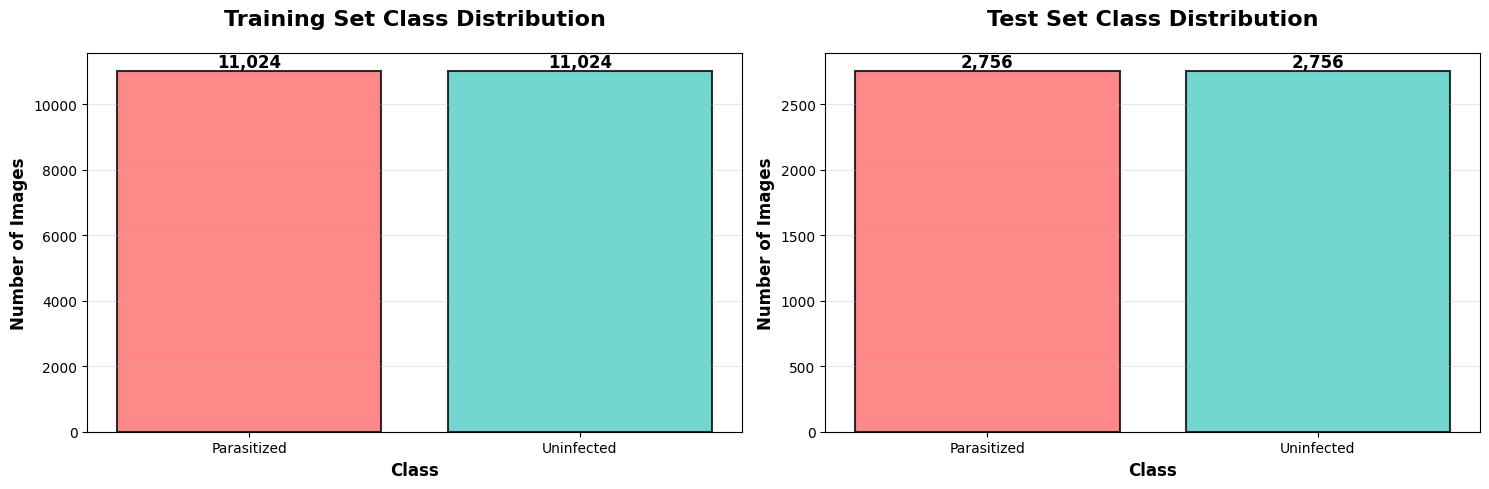

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1a: Training Set Distribution
categories = ['Parasitized', 'Uninfected']
train_counts = [train_parasitized, train_uninfected]
colors = ['#FF6B6B', '#4ECDC4']

bars1 = axes[0].bar(categories, train_counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_title('Training Set Class Distribution', fontsize=16, fontweight='bold', pad=20)
axes[0].set_ylabel('Number of Images', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Class', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add count labels on bars
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Plot 1b: Test Set Distribution
test_counts = [test_parasitized, test_uninfected]
bars2 = axes[1].bar(categories, test_counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_title('Test Set Class Distribution', fontsize=16, fontweight='bold', pad=20)
axes[1].set_ylabel('Number of Images', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Class', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add count labels on bars
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('class_distribution_bars.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Data Preprocessing

This section implements comprehensive data preprocessing including train/test splitting, image resizing, normalization, and data augmentation.

Data directories:
  Train: /home/belysetag/malaria-diagnosis-ml-pipeline/data/train
  Test: /home/belysetag/malaria-diagnosis-ml-pipeline/data/test
Found 17639 images belonging to 2 classes.
Found 4408 images belonging to 2 classes.
Found 4408 images belonging to 2 classes.
Found 5511 images belonging to 2 classes.
Found 5511 images belonging to 2 classes.
Data generators created successfully!
Training samples: 17639
Validation samples: 4408
Test samples: 5511
Image size: (128, 128)
Batch size: 32
Classes: {'Parasitized': 0, 'Uninfected': 1}

Sample augmented images:
Data generators created successfully!
Training samples: 17639
Validation samples: 4408
Test samples: 5511
Image size: (128, 128)
Batch size: 32
Classes: {'Parasitized': 0, 'Uninfected': 1}

Sample augmented images:


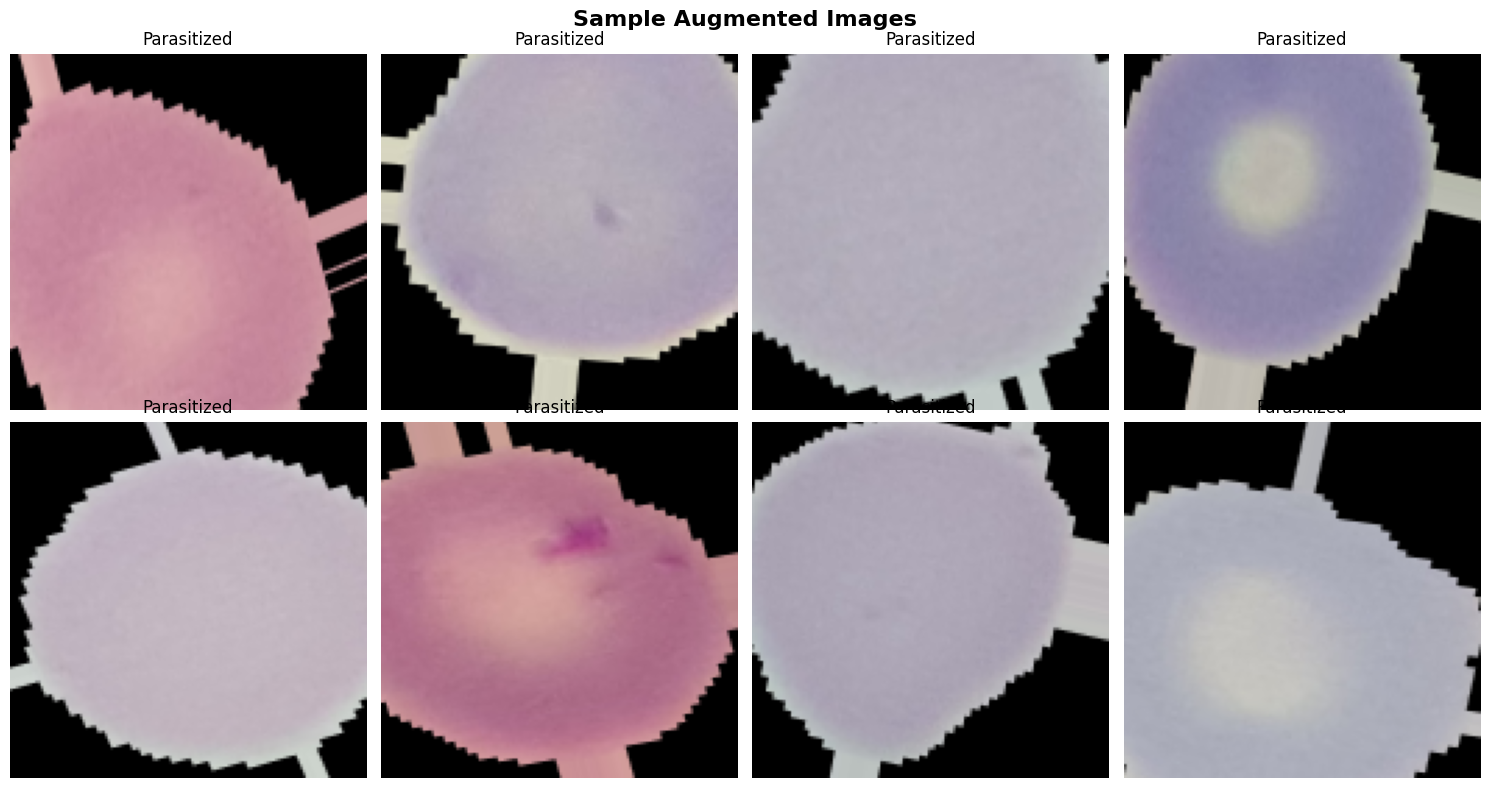

In [36]:
# Data preprocessing and augmentation setup
# Define data directories
data_dir = '/home/belysetag/malaria-diagnosis-ml-pipeline/data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print(f"Data directories:")
print(f"  Train: {train_dir}")
print(f"  Test: {test_dir}")

def create_data_generators(train_dir, test_dir, img_size=(128, 128), batch_size=32):
    """Create data generators with augmentation for training and validation"""
    
    # Training data generator with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,                    # Normalize pixel values
        rotation_range=20,                 # Random rotation
        width_shift_range=0.2,             # Random horizontal shift
        height_shift_range=0.2,            # Random vertical shift
        shear_range=0.2,                   # Shear transformation
        zoom_range=0.2,                    # Random zoom
        horizontal_flip=True,              # Random horizontal flip
        fill_mode='nearest',               # Fill strategy for augmentation
        validation_split=0.2               # 20% for validation
    )
    
    # Test data generator (only rescaling, no augmentation)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Create generators
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='training',
        shuffle=True,
        seed=42
    )
    
    validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation',
        shuffle=True,
        seed=42
    )
    
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )
    
    return train_generator, validation_generator, test_generator

# Configure image parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Create data generators
train_gen, val_gen, test_gen = create_data_generators(train_dir, test_dir, IMG_SIZE, BATCH_SIZE)

print("Data generators created successfully!")
print(f"Training samples: {train_gen.samples}")
print(f"Validation samples: {val_gen.samples}")
print(f"Test samples: {test_gen.samples}")
print(f"Image size: {IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Classes: {train_gen.class_indices}")

# Display sample augmented images
def show_augmented_samples(generator, n_samples=8):
    """Display sample augmented images"""
    
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()
    
    # Get a batch of augmented images
    images, labels = next(generator)
    
    for i in range(min(n_samples, len(images))):
        axes[i].imshow(images[i])
        class_name = 'Parasitized' if labels[i] == 1 else 'Uninfected'
        axes[i].set_title(f'{class_name}')
        axes[i].axis('off')
    
    plt.suptitle('Sample Augmented Images', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\nSample augmented images:")
show_augmented_samples(train_gen)

In [ ]:
# # Set consistent image size
# IMG_SIZE = (64, 64)  # Original size you were using

# # Define paths
# training_path = '/home/belysetag/malaria-diagnosis-ml-pipeline/data/train'
# testing_path = '/home/belysetag/malaria-diagnosis-ml-pipeline/data/test'    

# # Image data generators for data augmentation
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )
# test_datagen = ImageDataGenerator(
#     rescale=1./255
# )
# # Create data generators
# train_generator = train_datagen.flow_from_directory(
#     training_path,
#     target_size=(64, 64),
#     batch_size=32,
#     class_mode='binary'
# )
# test_generator = test_datagen.flow_from_directory(
#     testing_path,
#     target_size=(64, 64),
#     batch_size=32,
#     class_mode='binary',
#     shuffle=False
# )

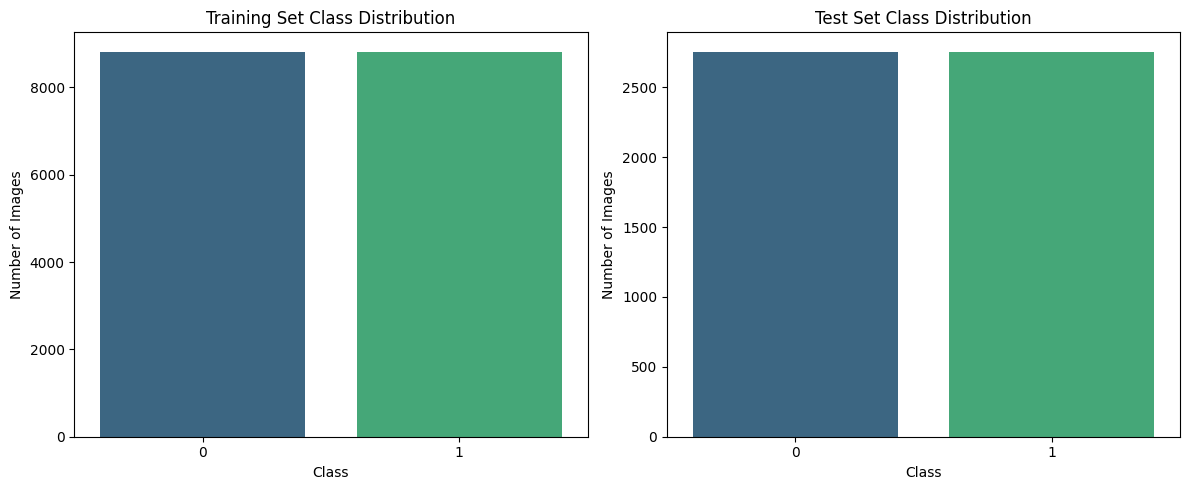

In [37]:
#check the class distribution both in train and test sets
train_class_counts = train_gen.classes
test_class_counts = test_gen.classes
unique, counts = np.unique(train_class_counts, return_counts=True)
train_class_distribution = dict(zip(unique, counts))
unique, counts = np.unique(test_class_counts, return_counts=True)
test_class_distribution = dict(zip(unique, counts))
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=list(train_class_distribution.keys()), y=list(train_class_distribution.values()), palette='viridis')
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.subplot(1, 2, 2)
sns.barplot(x=list(test_class_distribution.keys()), y=list(test_class_distribution.values()), palette='viridis')
plt.title('Test Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

Models directory created: /home/belysetag/malaria-diagnosis-ml-pipeline/models
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Improved MobileNetV2 Model Architecture:
Improved MobileNetV2 Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,086,913 (11.78 MB)

 Trainable params: 824,577 (3.15 MB)

 Non-trainable params: 2,262,336 (8.63 MB)


Model Parameters Summary:
Total parameters: 3,086,913
Trainable parameters: 824,577
Non-trainable parameters: 2,262,336

Starting training with:
Training samples: 17639
Validation samples: 4408
Epoch 1/25
Epoch 1/25
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.8193 - loss: 0.4261 - precision: 0.8093 - recall: 0.8348
Epoch 1: val_accuracy improved from None to 0.89439, saving model to /home/belysetag/malaria-diagnosis-ml-pipeline/models/best_malaria_mobilenet_improved.h5

Epoch 1: val_accuracy improved from None to 0.89439, saving model to /home/belysetag/malaria-diagnosis-ml-pipeline/models/best_malaria_mobilenet_improved.h5


551/551 ━━━━━━━━━━━━━━━━━━━━ 281s 501ms/step - accuracy: 0.8491 - loss: 0.3612 - precision: 0.8395 - recall: 0.8632 - val_accuracy: 0.8944 - val_loss: 0.2861 - val_precision: 0.8725 - val_recall: 0.9238 - learning_rate: 0.0010
Epoch 2/25
Epoch 2/25
  1/551 ━━━━━━━━━━━━━━━━━━━━ 3:22 369ms/step - accuracy: 0.9062 - loss: 0.2687 - precision: 0.8824 - recall: 0.9375
Epoch 2: val_accuracy did not improve from 0.89439
551/551 ━━━━━━━━━━━━━━━━━━━━ 55s 99ms/step - accuracy: 0.9062 - loss: 0.2687 - precision: 0.8824 - recall: 0.9375 - val_accuracy: 0.8921 - val_loss: 0.2899 - val_precision: 0.8621 - val_recall: 0.9334 - learning_rate: 0.0010
Epoch 3/25

Epoch 2: val_accuracy did not improve from 0.89439
551/551 ━━━━━━━━━━━━━━━━━━━━ 55s 99ms/step - accuracy: 0.9062 - loss: 0.2687 - precision: 0.8824 - recall: 0.9375 - val_accuracy: 0.8921 - val_loss: 0.2899 - val_precision: 0.8621 - val_recall: 0.9334 - learning_rate: 0.0010
Epoch 3/25
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.874

551/551 ━━━━━━━━━━━━━━━━━━━━ 272s 494ms/step - accuracy: 0.8863 - loss: 0.2890 - precision: 0.8692 - recall: 0.9093 - val_accuracy: 0.9053 - val_loss: 0.2540 - val_precision: 0.8808 - val_recall: 0.9375 - learning_rate: 0.0010
Epoch 6/25
Epoch 6/25
  1/551 ━━━━━━━━━━━━━━━━━━━━ 2:54 318ms/step - accuracy: 0.8750 - loss: 0.3027 - precision: 0.8889 - recall: 0.8889
Epoch 6: val_accuracy did not improve from 0.90534
551/551 ━━━━━━━━━━━━━━━━━━━━ 54s 97ms/step - accuracy: 0.8750 - loss: 0.3027 - precision: 0.8889 - recall: 0.8889 - val_accuracy: 0.8994 - val_loss: 0.2696 - val_precision: 0.8755 - val_recall: 0.9311 - learning_rate: 0.0010
Epoch 7/25

Epoch 6: val_accuracy did not improve from 0.90534
551/551 ━━━━━━━━━━━━━━━━━━━━ 54s 97ms/step - accuracy: 0.8750 - loss: 0.3027 - precision: 0.8889 - recall: 0.8889 - val_accuracy: 0.8994 - val_loss: 0.2696 - val_precision: 0.8755 - val_recall: 0.9311 - learning_rate: 0.0010
Epoch 7/25
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.889

551/551 ━━━━━━━━━━━━━━━━━━━━ 82s 149ms/step - accuracy: 0.9375 - loss: 0.1639 - precision: 0.9375 - recall: 0.9375 - val_accuracy: 0.9058 - val_loss: 0.2462 - val_precision: 0.8903 - val_recall: 0.9256 - learning_rate: 2.0000e-04
Epoch 11/25
Epoch 11/25
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.8946 - loss: 0.2656 - precision: 0.8774 - recall: 0.9166
Epoch 11: val_accuracy did not improve from 0.90579
551/551 ━━━━━━━━━━━━━━━━━━━━ 278s 504ms/step - accuracy: 0.8944 - loss: 0.2658 - precision: 0.8776 - recall: 0.9168 - val_accuracy: 0.9047 - val_loss: 0.2489 - val_precision: 0.8835 - val_recall: 0.9319 - learning_rate: 2.0000e-04
Epoch 12/25

Epoch 11: val_accuracy did not improve from 0.90579
551/551 ━━━━━━━━━━━━━━━━━━━━ 278s 504ms/step - accuracy: 0.8944 - loss: 0.2658 - precision: 0.8776 - recall: 0.9168 - val_accuracy: 0.9047 - val_loss: 0.2489 - val_precision: 0.8835 - val_recall: 0.9319 - learning_rate: 2.0000e-04
Epoch 12/25
  1/551 ━━━━━━━━━━━━━━━━━━━━ 3:11 348ms/s

551/551 ━━━━━━━━━━━━━━━━━━━━ 54s 98ms/step - accuracy: 0.9375 - loss: 0.2662 - precision: 0.9444 - recall: 0.9444 - val_accuracy: 0.9062 - val_loss: 0.2439 - val_precision: 0.8866 - val_recall: 0.9322 - learning_rate: 4.0000e-05
Epoch 15/25
Epoch 15/25
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.8998 - loss: 0.2564 - precision: 0.8829 - recall: 0.9236
Epoch 15: val_accuracy did not improve from 0.90625
551/551 ━━━━━━━━━━━━━━━━━━━━ 276s 501ms/step - accuracy: 0.8990 - loss: 0.2560 - precision: 0.8803 - recall: 0.9234 - val_accuracy: 0.9008 - val_loss: 0.2548 - val_precision: 0.8784 - val_recall: 0.9301 - learning_rate: 4.0000e-05
Epoch 16/25

Epoch 15: val_accuracy did not improve from 0.90625
551/551 ━━━━━━━━━━━━━━━━━━━━ 276s 501ms/step - accuracy: 0.8990 - loss: 0.2560 - precision: 0.8803 - recall: 0.9234 - val_accuracy: 0.9008 - val_loss: 0.2548 - val_precision: 0.8784 - val_recall: 0.9301 - learning_rate: 4.0000e-05
Epoch 16/25
  1/551 ━━━━━━━━━━━━━━━━━━━━ 3:12 350ms/st

551/551 ━━━━━━━━━━━━━━━━━━━━ 55s 99ms/step - accuracy: 0.9688 - loss: 0.1481 - precision: 1.0000 - recall: 0.9444 - val_accuracy: 0.9117 - val_loss: 0.2373 - val_precision: 0.8966 - val_recall: 0.9306 - learning_rate: 4.0000e-05
Epoch 17/25
Epoch 17/25
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.8951 - loss: 0.2589 - precision: 0.8777 - recall: 0.9171
Epoch 17: val_accuracy did not improve from 0.91172
551/551 ━━━━━━━━━━━━━━━━━━━━ 274s 498ms/step - accuracy: 0.8958 - loss: 0.2607 - precision: 0.8790 - recall: 0.9180 - val_accuracy: 0.9015 - val_loss: 0.2543 - val_precision: 0.8785 - val_recall: 0.9315 - learning_rate: 4.0000e-05

Epoch 17: val_accuracy did not improve from 0.91172
551/551 ━━━━━━━━━━━━━━━━━━━━ 274s 498ms/step - accuracy: 0.8958 - loss: 0.2607 - precision: 0.8790 - recall: 0.9180 - val_accuracy: 0.9015 - val_loss: 0.2543 - val_precision: 0.8785 - val_recall: 0.9315 - learning_rate: 4.0000e-05
Epoch 18/25
Epoch 18/25
  1/551 ━━━━━━━━━━━━━━━━━━━━ 3:17 359ms/st

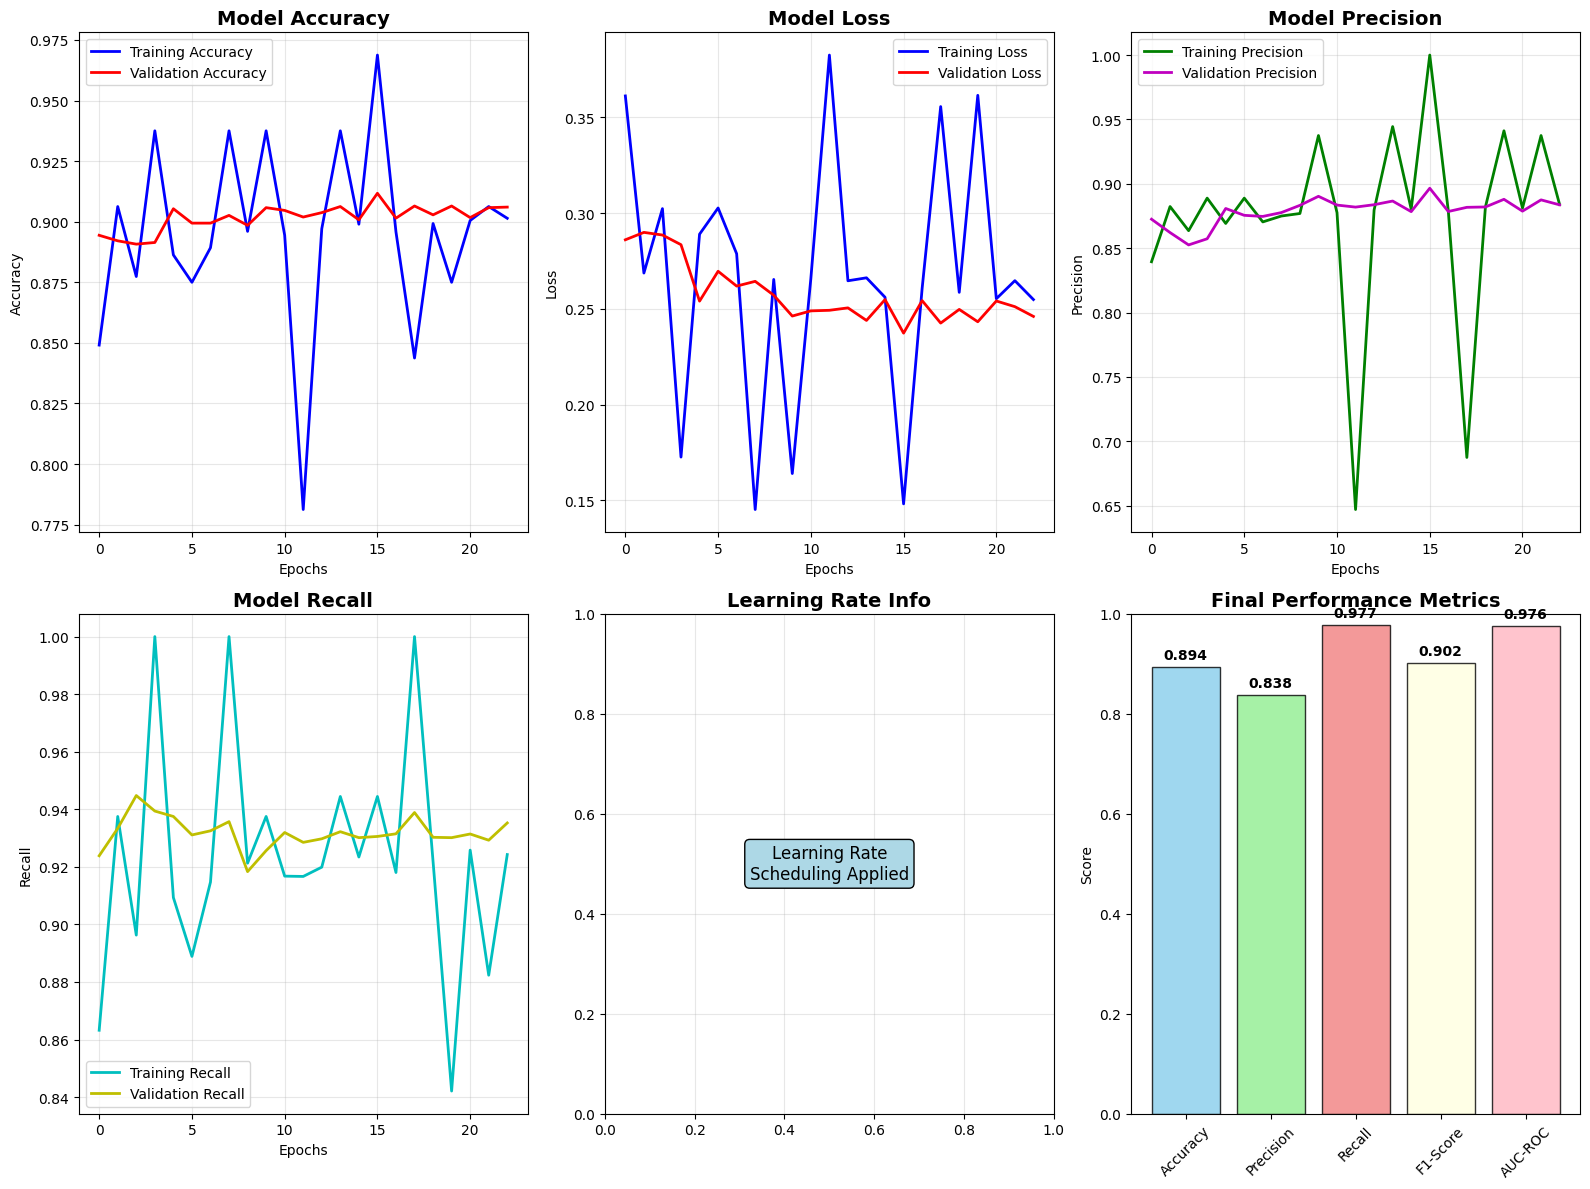


 MODEL TRAINING COMPLETED!
Best model: /home/belysetag/malaria-diagnosis-ml-pipeline/models/best_malaria_mobilenet_improved.h5
Final model: /home/belysetag/malaria-diagnosis-ml-pipeline/models/malaria_classification_mobilenet_improved.h5
Training history: /home/belysetag/malaria-diagnosis-ml-pipeline/models/training_history_mobilenet_improved.pkl


In [38]:
# Create models directory if it doesn't exist
models_dir = '/home/belysetag/malaria-diagnosis-ml-pipeline/models'
os.makedirs(models_dir, exist_ok=True)
print(f"Models directory created: {models_dir}")

# Build improved model using Transfer Learning with MobileNetV2
base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add custom layers with multiple hidden layers and batch normalization
model = Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    
    # Batch normalization for stable training
    BatchNormalization(),
    
    # First hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    # Second hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    
    # Third hidden layer
    tf.keras.layers.Dense(128, activation='relu'),
    BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    # Output layer for binary classification
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with additional metrics
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])

# Print model summary
print("Improved MobileNetV2 Model Architecture:")

model.summary()

# Count parameters
total_params = model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = total_params - trainable_params

print(f"\nModel Parameters Summary:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {non_trainable_params:,}")

# Improved callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
model_checkpoint = ModelCheckpoint(os.path.join(models_dir, 'best_malaria_mobilenet_improved.h5'), 
                                 monitor='val_accuracy', save_best_only=True, verbose=1)


# Train the improved model
print(f"\nStarting training with:")
print(f"Training samples: {train_gen.samples}")
print(f"Validation samples: {val_gen.samples}")


history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    validation_data=val_gen,  # Using proper validation set
    validation_steps=val_gen.samples // val_gen.batch_size,
    epochs=25,  # Increased epochs with early stopping
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

# Evaluate the model on test set
test_gen.reset()
y_pred_prob = model.predict(test_gen)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)
y_true = test_gen.classes

# Calculate comprehensive evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, target_names=['Uninfected', 'Parasitized'])

# Additional metrics
from sklearn.metrics import roc_auc_score, matthews_corrcoef
auc_score = roc_auc_score(y_true, y_pred_prob)
mcc = matthews_corrcoef(y_true, y_pred)

# Print comprehensive evaluation metrics
print("\n" + "=" * 60)
print("COMPREHENSIVE EVALUATION RESULTS")

print(f"Accuracy:           {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision:          {precision:.4f}")
print(f"Recall:             {recall:.4f}")  
print(f"F1 Score:           {f1:.4f}")
print(f"AUC-ROC Score:      {auc_score:.4f}")
print(f"Matthews Corr Coef: {mcc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nDetailed Classification Report:")
print(class_report)

# Plot comprehensive training history
plt.figure(figsize=(16, 12))

# Plot accuracy
plt.subplot(2, 3, 1)
plt.plot(history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot loss
plt.subplot(2, 3, 2)
plt.plot(history.history['loss'], 'b-', label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot precision
plt.subplot(2, 3, 3)
if 'precision' in history.history:
    plt.plot(history.history['precision'], 'g-', label='Training Precision', linewidth=2)
    plt.plot(history.history['val_precision'], 'm-', label='Validation Precision', linewidth=2)
plt.title('Model Precision', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot recall
plt.subplot(2, 3, 4)
if 'recall' in history.history:
    plt.plot(history.history['recall'], 'c-', label='Training Recall', linewidth=2)
    plt.plot(history.history['val_recall'], 'y-', label='Validation Recall', linewidth=2)
plt.title('Model Recall', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot learning rate (if available)
plt.subplot(2, 3, 5)
if 'lr' in history.history:
    plt.plot(history.history['lr'], 'orange', label='Learning Rate', linewidth=2)
    plt.title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.yscale('log')
else:
    plt.text(0.5, 0.5, 'Learning Rate\nScheduling Applied', ha='center', va='center', 
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    plt.title('Learning Rate Info', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Plot metrics summary
plt.subplot(2, 3, 6)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
metrics_values = [accuracy, precision, recall, f1, auc_score]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink']
bars = plt.bar(metrics_names, metrics_values, color=colors, alpha=0.8, edgecolor='black')
plt.title('Final Performance Metrics', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Add value labels on bars
for bar, value in zip(bars, metrics_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Save the improved trained model
final_model_path = os.path.join(models_dir, 'malaria_classification_mobilenet_improved.h5')
model.save(final_model_path)

# Save training history
history_path = os.path.join(models_dir, 'training_history_mobilenet_improved.pkl')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)

print(f"\n MODEL TRAINING COMPLETED!")
print(f"Best model: {os.path.join(models_dir, 'best_malaria_mobilenet_improved.h5')}")
print(f"Final model: {final_model_path}")
print(f"Training history: {history_path}")
